## Librerias

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Deshabilitar el modo interactivo
plt.ioff()

## Funciones

In [2]:
class Graficador:

    def __init__(self):
        pass

    def create_subplots_one_var(self,data, n_rows, n_cols, graph, fig_size = (30,25)):
        # Indices de la grilla de graficos de matplotlib
        i = 0
        j = 0

        # Creacion de la grilla de graficos
        fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = fig_size)

        for column in data.columns:

            # Creacion del grafico de barras
            graph(data = data[[column]], ax = axes[i,j])

            # Se añade el titulo a la grafica
            axes[i,j].set_title(f'{column}')

            # Indices para poder ir agregando los graficos
            j += 1
            if j > n_cols - 1:
                j = 0
                i+=1

        return fig, axes

    def create_subplots_one_var_group(self, data, n_rows, n_cols, graph, fig_size = (30,25)):
        # Indices de la grilla de graficos de matplotlib
        i = 0
        j = 0

        # Creacion de la grilla de graficos
        fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = fig_size)
        data_temp = data[::]
        data_temp['temp'] = 0
        for column in data_temp.columns:
            
            if column == 'temp':
                continue

            temp = data_temp[[column, 'temp']].groupby(column, as_index = False).count().rename(columns = {'temp' : 'Conteo'})
            # Creacion del grafico de barras
            graph(data = temp, x = column, y = 'Conteo', ax = axes[i,j])

            # Se añade el titulo a la grafica
            axes[i,j].set_title(f'{column}')

            # Indices para poder ir agregando los graficos
            j += 1
            if j > n_cols - 1:
                j = 0
                i+=1

        return fig, axes

def create_apilated_bars(data):

    grupos = data.columns

    fig, ax = plt.subplots()
    values = data.values

    for i in range(values.shape[0]):
        ax.bar(grupos, values[i], bottom = np.sum(values[:i], axis = 0), label = data.index[i])
        # Agregar títulos a los ejes

    return fig,ax


def outlier_label(value, limit):
    if value < limit[0]:
        return 'Abajo'
    elif value > limit[1]:
        return 'Arriba'
    else:
        return 'No'

def take_outliers(data, variable):
    Q1 = data[variable].quantile(0.25)
    Q3 = data[variable].quantile(0.75)
    RIC = Q3 - Q1
    limit_inf = Q1 - (1.5 * RIC)
    limit_sup = Q3 + (1.5 * RIC)
    data[f'{variable}_outlier'] = data[variable].apply(lambda x: outlier_label(x, [limit_inf,limit_sup]))
    return data

## Parametros

In [3]:
client_bq = bigquery.Client()

In [35]:
table = 'Diabetes_avicena_survival.diabetes_final_3_annos'

variables_with_outliers = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal']

numeric_columns = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal','time_to_event']
categoric_columns = ['genero_paciente','raza_paciente','nivel_academico_paciente','ant_cardio','med_hipertension','ant_familiar_dm','hace_ejercicio']
target = 'diabetes'

In [5]:
graficador = Graficador()

## Proceso

In [36]:
data = client_bq.query(f'SELECT * FROM {table}').result().to_dataframe()
print(f'Se trajo {data.shape} datos de pacientes')
data.head()

Se trajo (270767, 21) datos de pacientes


,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,LDL,...,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
0,42995991,2022,2,2022-02-01,63,64.3,1.63,24.201136663,66.0,166.50,...,78.0,Femenino,Otros,Ninguno,1,1,0,None,0,35
1,44155333,2022,2,2022-02-01,40,75.9,1.49,34.187649205,29.5,64.30,...,88.0,Femenino,Otros,Profesional,1,1,0,None,0,34
2,447022,2022,2,2022-02-01,70,87.0,1.77,27.769797951,49.0,113.80,...,NaN,Masculino,Otros,Ninguno,1,1,0,None,0,11
3,45452118,2022,2,2022-02-01,60,60.0,1.60,23.437500000,38.0,125.00,...,NaN,Femenino,Otros,Ninguno,0,0,0,None,0,29
4,45478698,2022,2,2022-02-01,56,73.0,1.63,27.475629493,72.3,59.76,...,94.0,Femenino,Otros,Normalista,1,0,0,None,0,32


In [44]:
## Cantidad de pacientes con diabetes
dia = data[['numero_identificacion_paciente','diabetes']].drop_duplicates().groupby('diabetes', as_index = False).count()
dia['porcentaje'] = round((dia['numero_identificacion_paciente']/ len(data)*100),2)
dia

,diabetes,numero_identificacion_paciente,porcentaje
0,0,209095,77.22
1,1,61672,22.78


In [45]:
# Dataframe con los datos numericos
df_numerico = data[numeric_columns]
df_numerico['IMC'] = np.round(df_numerico['IMC'].astype(float),2)

df_numerico.head()

,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,time_to_event
0,63,24.20,66.0,166.50,141.0,78.0,35
1,40,34.19,29.5,64.30,478.0,88.0,34
2,70,27.77,49.0,113.80,286.0,NaN,11
3,60,23.44,38.0,125.00,132.0,NaN,29
4,56,27.48,72.3,59.76,73.2,94.0,32


In [46]:
# Dataframe con los datos categoricos
df_categorico = data[categoric_columns + [target]].astype(str)

df_categorico.head()

,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes
0,Femenino,Otros,Ninguno,1,1,0,None,0
1,Femenino,Otros,Profesional,1,1,0,None,0
2,Masculino,Otros,Ninguno,1,1,0,None,0
3,Femenino,Otros,Ninguno,0,0,0,None,0
4,Femenino,Otros,Normalista,1,0,0,None,0


## Outliers

In [47]:
data_label = data.copy()
data_label['IMC'] = np.round(data_label['IMC'].astype(float),2)

In [48]:
for variable in variables_with_outliers:
    print(variable)
    data_label = take_outliers(data_label, variable)

edad
IMC
HDL
LDL
trigliceridos
perimetro_abdominal


In [49]:
for variable in variables_with_outliers + ['time_to_event']:
    print(variable)
    if variable == 'time_to_event':
        conteos = data_label[f'{variable}'].value_counts().reset_index()
    else: 
        conteos = data_label[f'{variable}_outlier'].value_counts().reset_index()
    total = conteos['count'].sum()
    conteos['Porcentaje'] = (conteos['count'] / total)*100
    display(conteos)

edad


,edad_outlier,count,Porcentaje
0,No,270765,99.999261
1,Arriba,2,0.000739


IMC


,IMC_outlier,count,Porcentaje
0,No,264031,97.512252
1,Arriba,6407,2.366241
2,Abajo,329,0.121507


HDL


,HDL_outlier,count,Porcentaje
0,No,263809,97.430263
1,Arriba,6826,2.520987
2,Abajo,132,0.048750


LDL


,LDL_outlier,count,Porcentaje
0,No,268003,98.979196
1,Arriba,2637,0.973900
2,Abajo,127,0.046904


trigliceridos


,trigliceridos_outlier,count,Porcentaje
0,No,258977,95.645703
1,Arriba,11790,4.354297


perimetro_abdominal


,perimetro_abdominal_outlier,count,Porcentaje
0,No,268193,99.049367
1,Arriba,2015,0.744182
2,Abajo,559,0.206451


time_to_event


,time_to_event,count,Porcentaje
0,32,15101,5.57712
1,31,13908,5.13652
2,33,13491,4.982513
3,30,12003,4.432963
4,34,11616,4.290035
5,29,10967,4.050346
6,28,10210,3.77077
7,27,9472,3.498211
8,26,7967,2.942382
9,3,7732,2.855592


In [50]:
columns_to_drop = [column + '_outlier' for column in variables_with_outliers]

data_clean_outliers = data_label[(data_label.edad_outlier == 'No') &
                                 (data_label.IMC_outlier == 'No') &
                                 (data_label.HDL_outlier == 'No') &
                                 (data_label.LDL_outlier == 'No') &
                                 (data_label.trigliceridos_outlier == 'No') &
                                 (data_label.perimetro_abdominal_outlier == 'No')
                                ]

data_clean_outliers = data_clean_outliers.drop(columns = columns_to_drop)

data_clean_outliers

,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,LDL,...,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
0,42995991,2022,2,2022-02-01,63,64.30,1.63,24.20,66.0,166.50,...,78.0,Femenino,Otros,Ninguno,1,1,0,None,0,35
2,447022,2022,2,2022-02-01,70,87.00,1.77,27.77,49.0,113.80,...,NaN,Masculino,Otros,Ninguno,1,1,0,None,0,11
3,45452118,2022,2,2022-02-01,60,60.00,1.60,23.44,38.0,125.00,...,NaN,Femenino,Otros,Ninguno,0,0,0,None,0,29
4,45478698,2022,2,2022-02-01,56,73.00,1.63,27.48,72.3,59.76,...,94.0,Femenino,Otros,Normalista,1,0,0,None,0,32
5,4717465,2022,2,2022-02-01,71,75.10,1.63,28.27,34.3,156.50,...,96.0,Masculino,Otros,Profesional,1,0,0,None,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270761,41412438,2025,1,2025-01-01,77,62.45,1.57,25.34,37.0,38.80,...,NaN,Femenino,Otros,Normalista,0,0,0,None,1,34
270762,41476080,2025,1,2025-01-01,80,60.00,1.50,26.67,55.0,91.00,...,90.0,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1,35
270764,63323735,2025,1,2025-01-01,60,78.90,1.62,30.06,55.9,71.50,...,98.0,Femenino,Otros,Profesional,0,0,0,None,1,34
270765,79511536,2025,1,2025-01-01,55,57.90,1.65,21.27,64.8,183.60,...,72.0,Masculino,Otros,Básica secundaria,0,0,0,None,1,19


In [51]:
data_clean_outliers = data_clean_outliers.drop(columns = ['peso','talla'])
data_clean_outliers

,numero_identificacion_paciente,year,month,fecha,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
0,42995991,2022,2,2022-02-01,63,24.20,66.0,166.50,141.00,78.0,Femenino,Otros,Ninguno,1,1,0,None,0,35
2,447022,2022,2,2022-02-01,70,27.77,49.0,113.80,286.00,NaN,Masculino,Otros,Ninguno,1,1,0,None,0,11
3,45452118,2022,2,2022-02-01,60,23.44,38.0,125.00,132.00,NaN,Femenino,Otros,Ninguno,0,0,0,None,0,29
4,45478698,2022,2,2022-02-01,56,27.48,72.3,59.76,73.20,94.0,Femenino,Otros,Normalista,1,0,0,None,0,32
5,4717465,2022,2,2022-02-01,71,28.27,34.3,156.50,221.00,96.0,Masculino,Otros,Profesional,1,0,0,None,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270761,41412438,2025,1,2025-01-01,77,25.34,37.0,38.80,251.00,NaN,Femenino,Otros,Normalista,0,0,0,None,1,34
270762,41476080,2025,1,2025-01-01,80,26.67,55.0,91.00,99.00,90.0,Femenino,Otros,Básica secundaria,0,0,0,Nunca,1,35
270764,63323735,2025,1,2025-01-01,60,30.06,55.9,71.50,143.00,98.0,Femenino,Otros,Profesional,0,0,0,None,1,34
270765,79511536,2025,1,2025-01-01,55,21.27,64.8,183.60,114.82,72.0,Masculino,Otros,Básica secundaria,0,0,0,None,1,19


In [52]:
data_clean_outliers.to_csv('datas_no_outliers.csv', sep = '|', index = False)

## One Variable

In [53]:
## informacion de la data
df_numerico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270767 entries, 0 to 270766
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   edad                 270767 non-null  Int64  
 1   IMC                  270767 non-null  float64
 2   HDL                  270767 non-null  float64
 3   LDL                  270767 non-null  float64
 4   trigliceridos        270767 non-null  float64
 5   perimetro_abdominal  124448 non-null  float64
 6   time_to_event        270767 non-null  Int64  
dtypes: Int64(2), float64(5)
memory usage: 15.0 MB


In [54]:
## Descripcion de los datos
df_numerico.describe()

,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,time_to_event
count,270767.0,270767.000000,270767.00000,270767.000000,270767.000000,124448.000000,270767.0
mean,58.343764,27.834033,48.58999,114.064395,155.767940,93.217999,20.456477
std,15.709811,5.306959,23.87699,68.041833,955.452151,12.593321,10.437796
min,18.0,0.130000,0.00000,-113.860000,0.000000,20.000000,1.0
25%,47.0,24.480000,39.50000,85.000000,97.000000,85.000000,12.0
50%,59.0,27.250000,46.90000,111.400000,132.900000,92.000000,22.0
75%,70.0,30.490000,55.10000,139.000000,183.000000,100.333333,30.0
max,111.0,350.260000,6708.00000,15034.000000,349000.000000,201.000000,36.0


Grafico de distribuciones


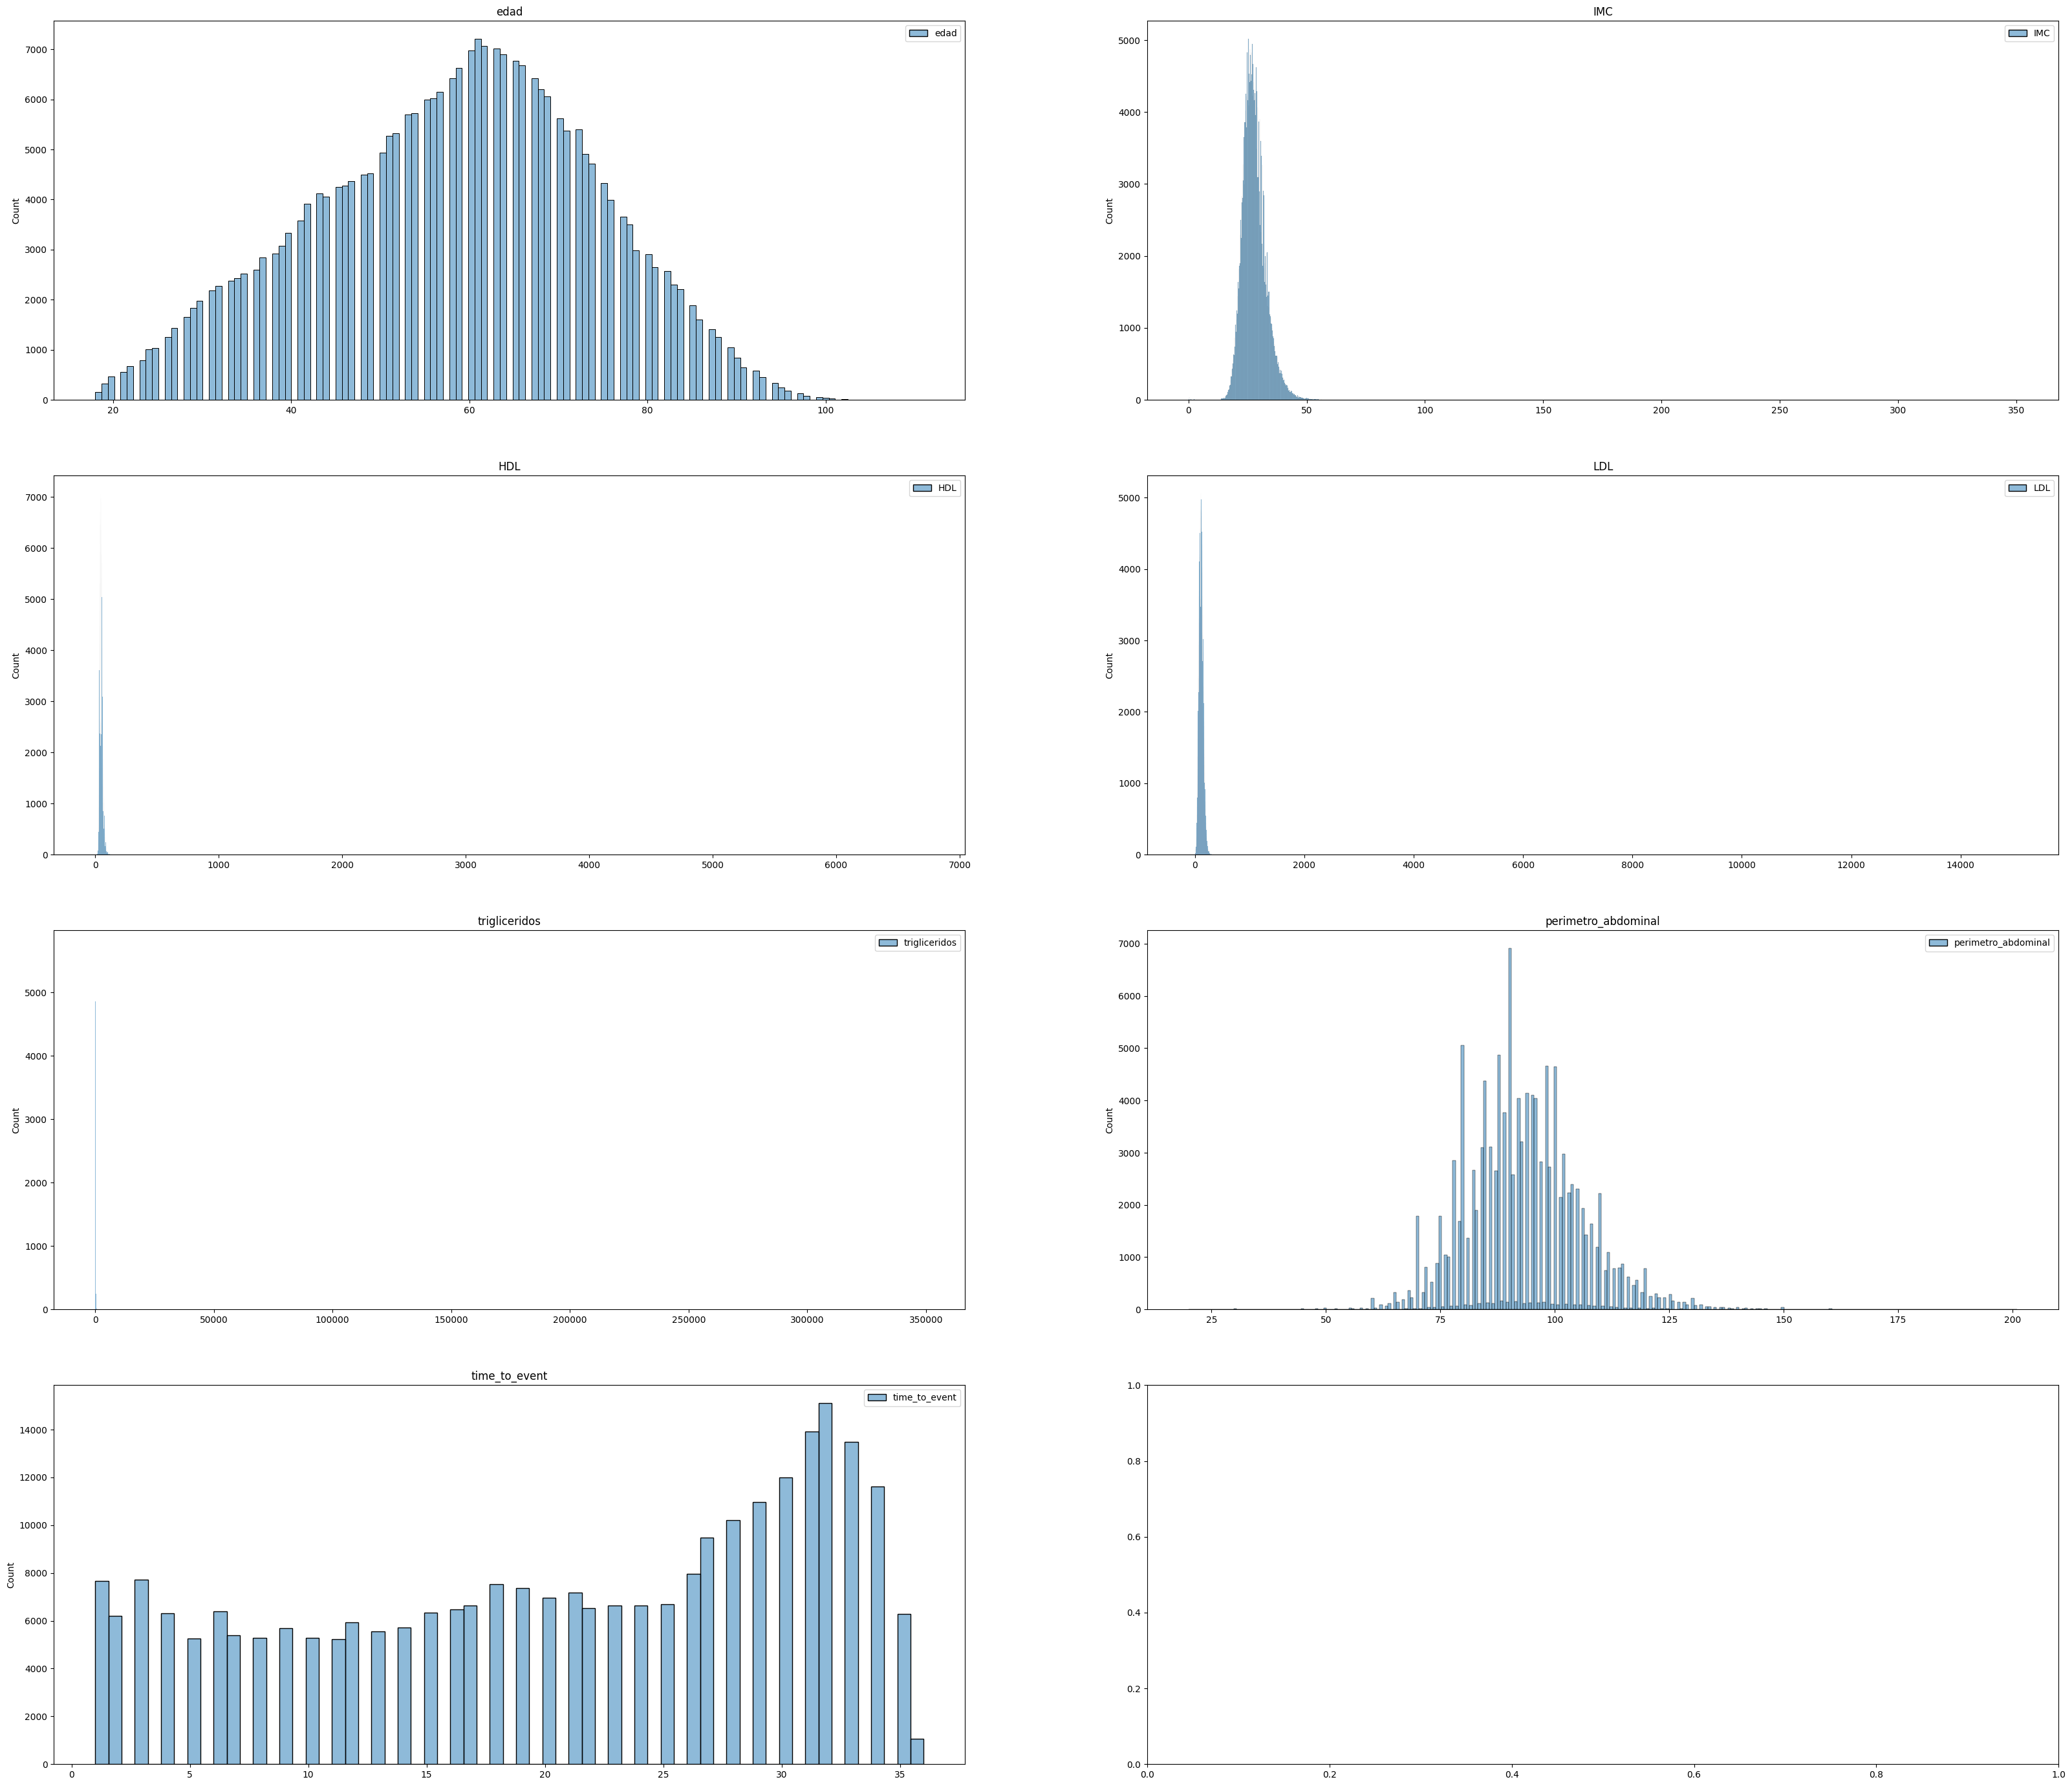

In [55]:
print('Grafico de distribuciones')
fig, axes = graficador.create_subplots_one_var(data = df_numerico, n_cols = 2, n_rows = 4, graph= sns.histplot, fig_size = (40,35))
plt.show()

Grafico de caja y bigotes


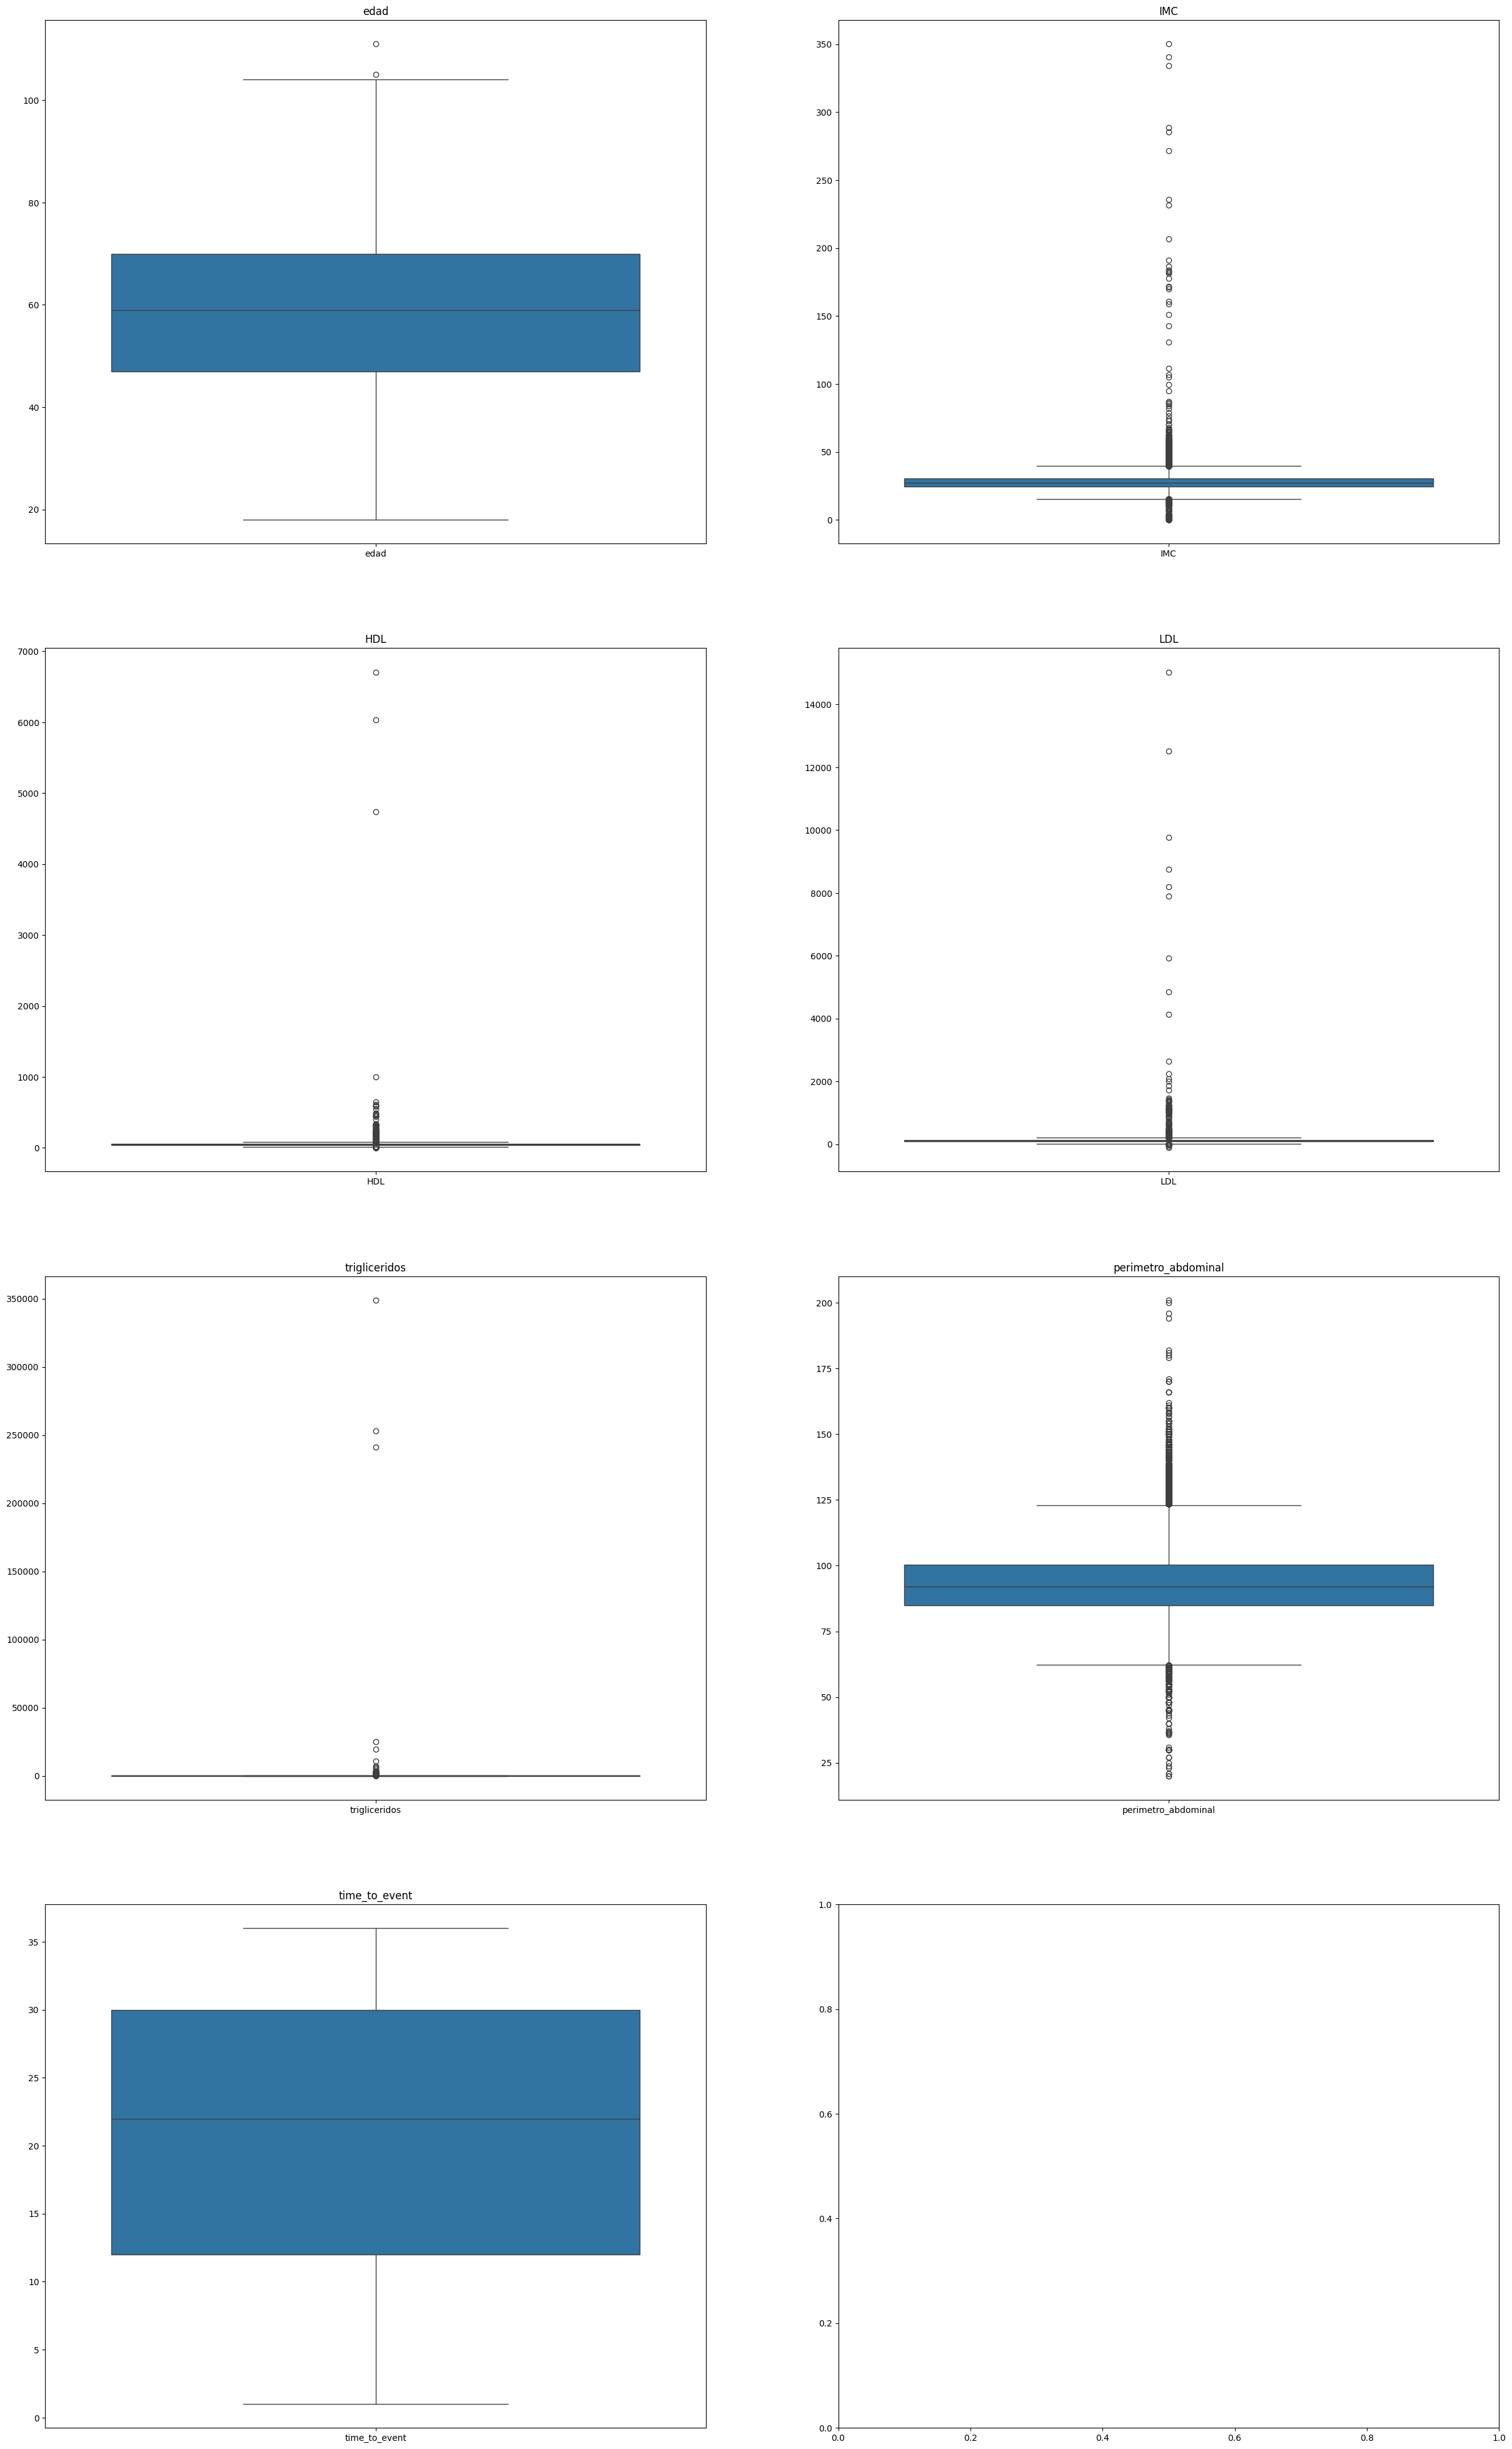

In [56]:
print('Grafico de caja y bigotes')
fig, axes = graficador.create_subplots_one_var(data = df_numerico, n_cols = 2, n_rows = 4, graph= sns.boxplot, fig_size=(30,50))
plt.show()

In [57]:
df_categorico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270767 entries, 0 to 270766
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   genero_paciente           270767 non-null  object
 1   raza_paciente             270767 non-null  object
 2   nivel_academico_paciente  270767 non-null  object
 3   ant_cardio                270767 non-null  object
 4   med_hipertension          270767 non-null  object
 5   ant_familiar_dm           270767 non-null  object
 6   hace_ejercicio            270767 non-null  object
 7   diabetes                  270767 non-null  object
dtypes: object(8)
memory usage: 16.5+ MB


Conteos de cada una de las categorias


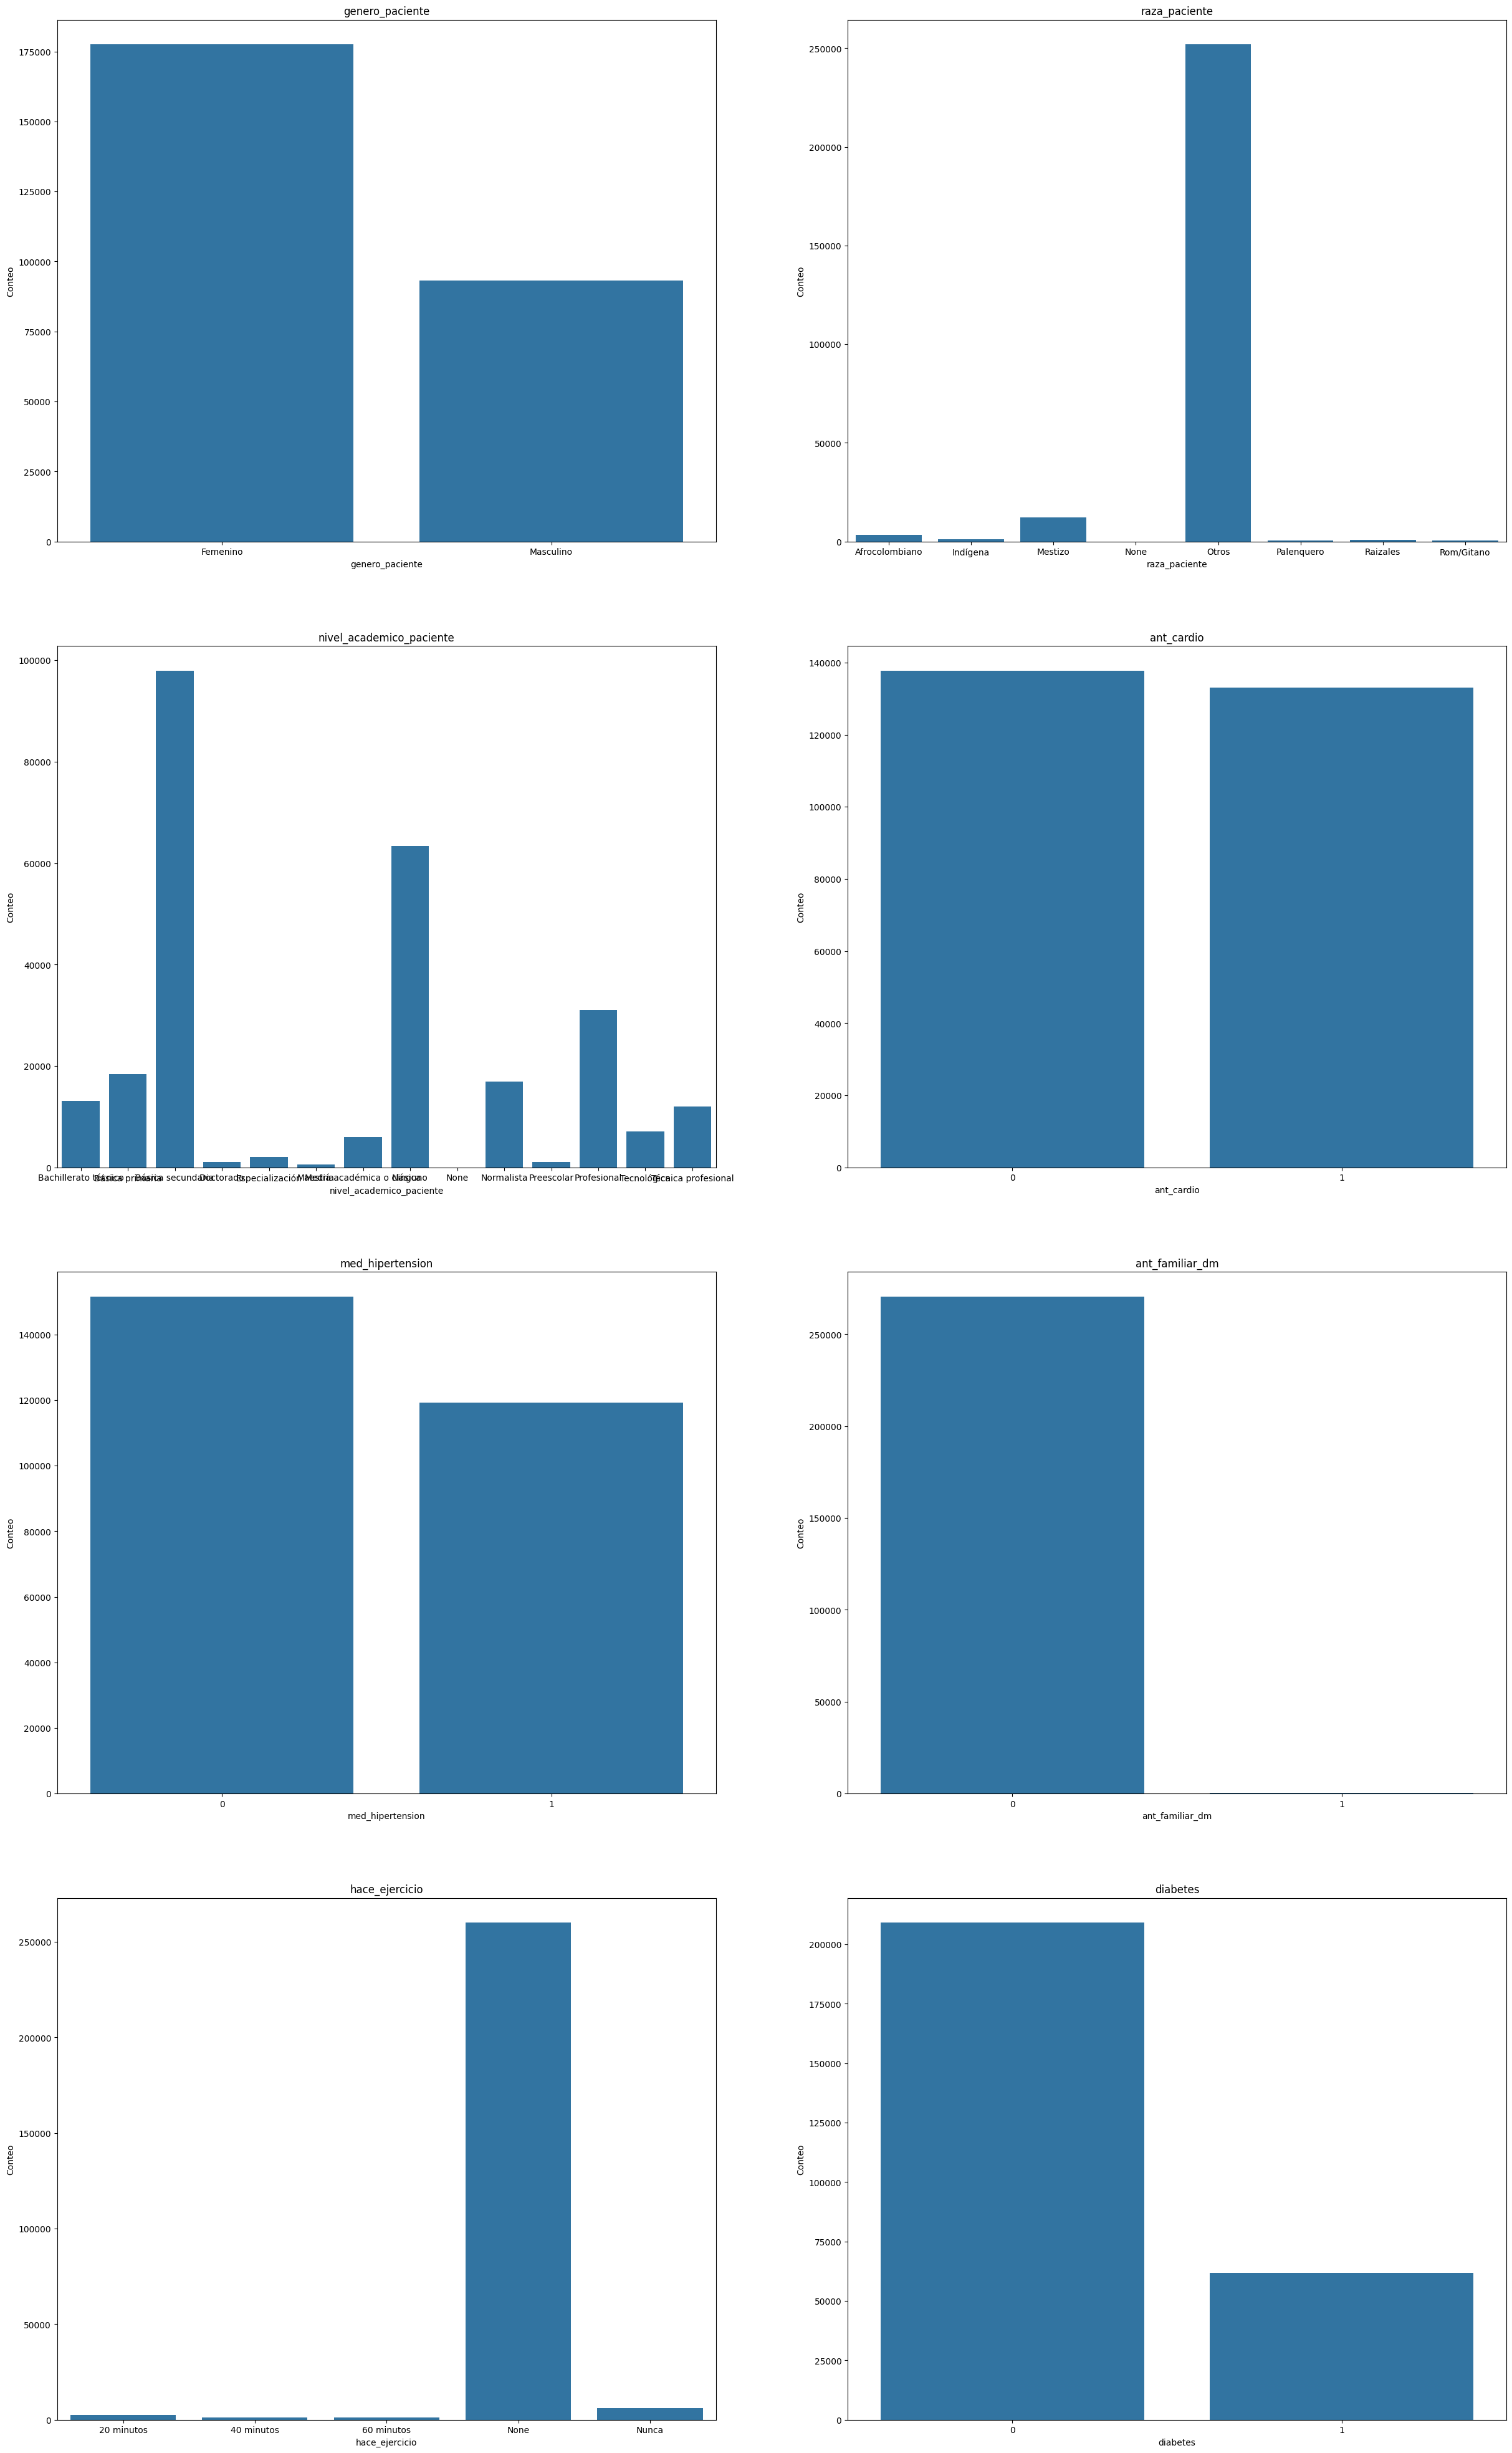

In [58]:
print('Conteos de cada una de las categorias')
fig, axes = graficador.create_subplots_one_var_group(data = df_categorico, n_cols = 2, n_rows = 4, graph= sns.barplot, fig_size=(30,50))
plt.show()

## Two Variables

Grafico de dispersion para cada par de variables


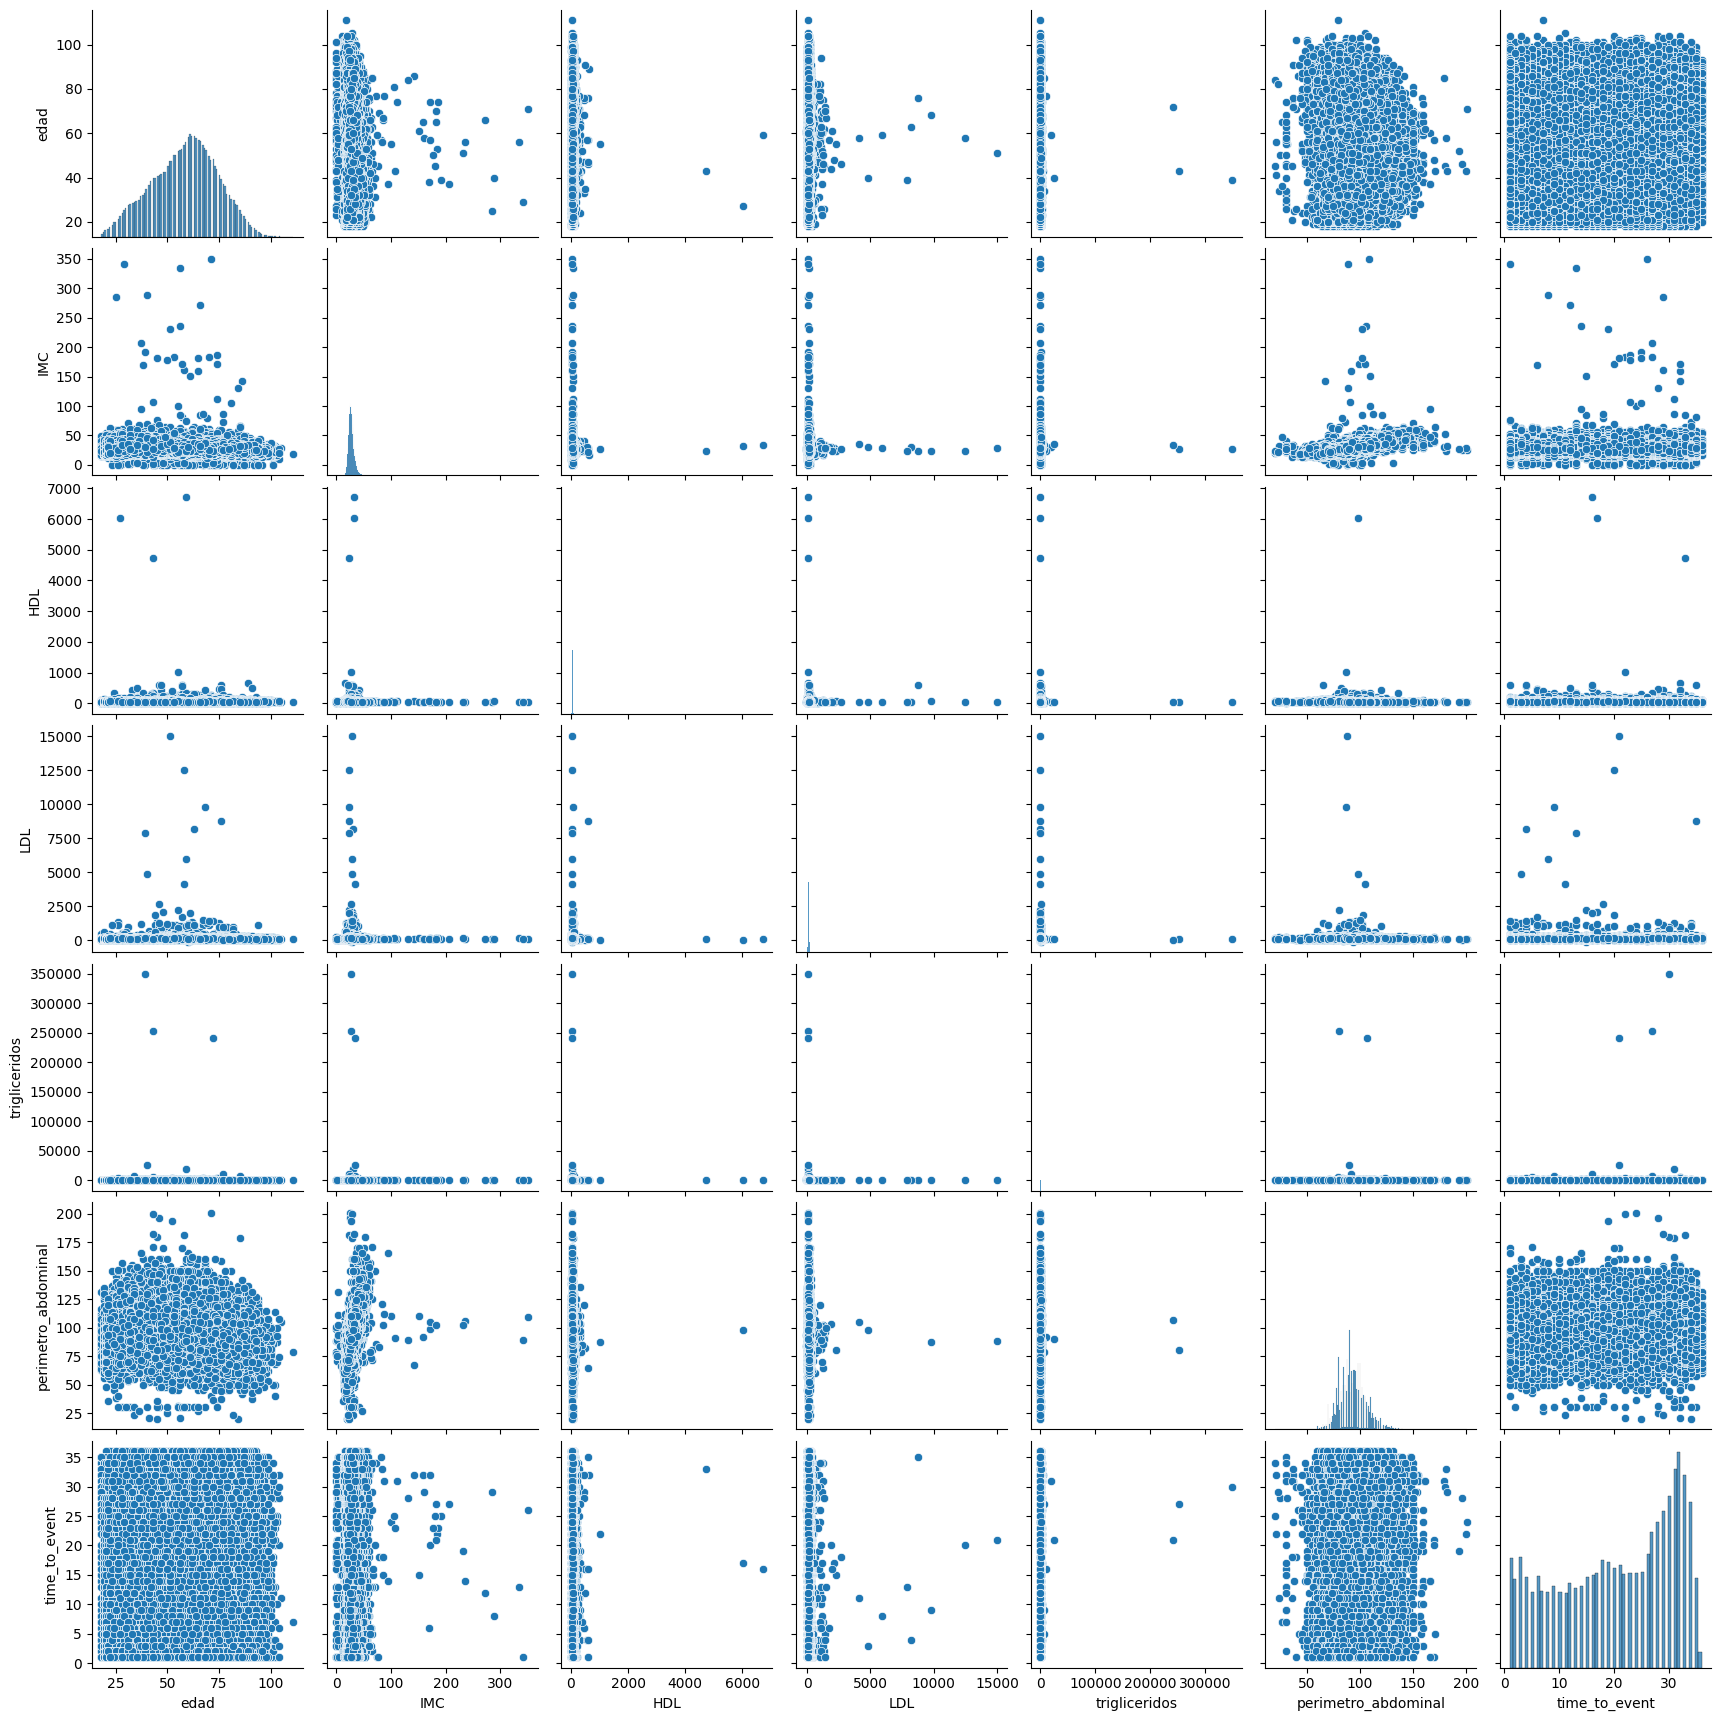

In [59]:
print('Grafico de dispersion para cada par de variables')
sns.pairplot(df_numerico)

In [60]:
print('Matriz de correlaciones')
px.imshow(np.round(df_numerico.corr(),2), text_auto=True, height=500, width=700)

Matriz de correlaciones


In [61]:
print('Matriz de covarianza')
df_numerico.cov()

Matriz de covarianza


,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,time_to_event
edad,246.798159,-11.291972,19.191627,-67.169729,-57.063607,-2.374967,18.393584
IMC,-11.291972,28.163814,-12.418072,-6.135410,64.958986,46.415390,-1.435027
HDL,19.191627,-12.418072,570.110655,64.778548,-462.485687,-39.286948,0.893753
LDL,-67.169729,-6.135410,64.778548,4629.691057,99.233301,-38.238686,-21.128993
trigliceridos,-57.063607,64.958986,-462.485687,99.233301,912888.812587,149.643285,19.298558
perimetro_abdominal,-2.374967,46.415390,-39.286948,-38.238686,149.643285,158.591723,-0.271690
time_to_event,18.393584,-1.435027,0.893753,-21.128993,19.298558,-0.271690,108.947582


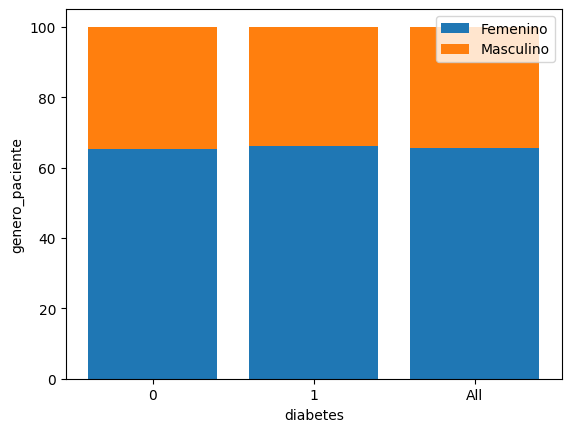

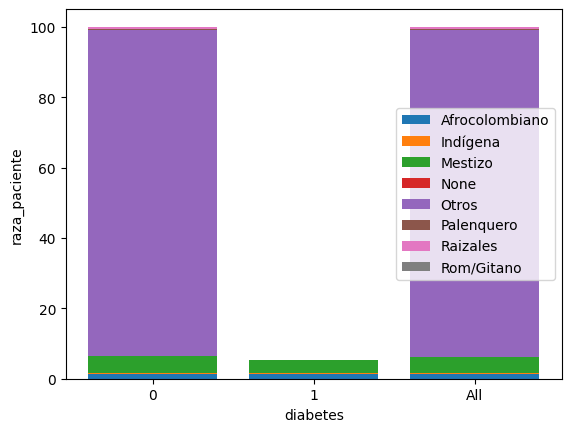

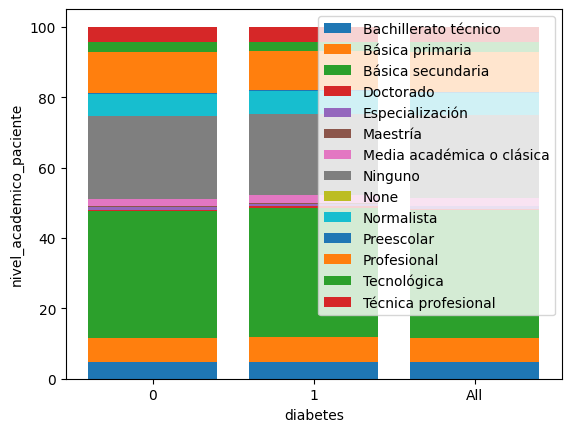

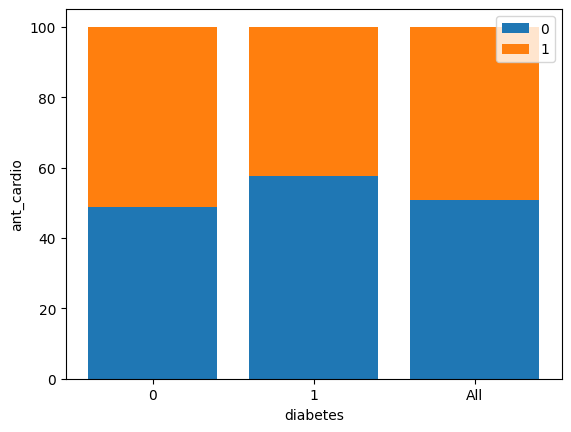

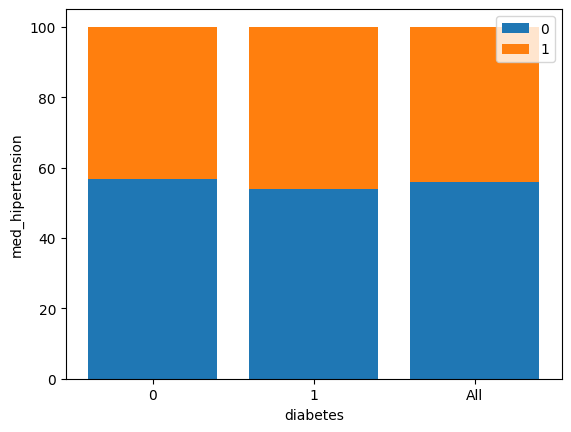

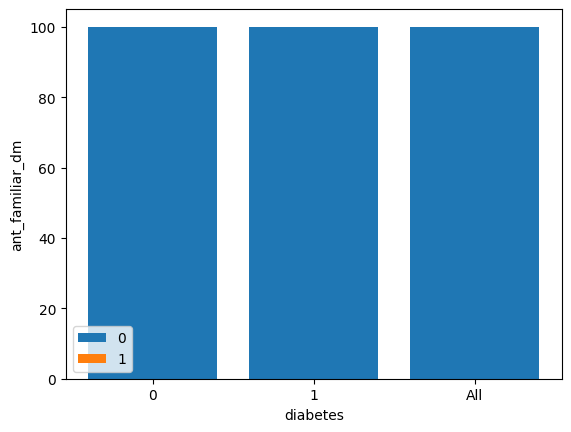

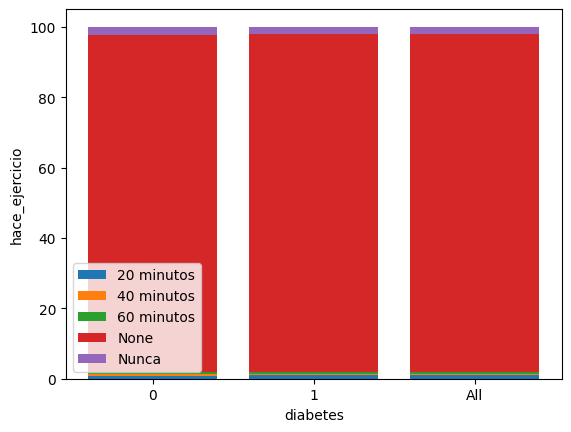

In [62]:
var2 = 'diabetes'

for column in df_categorico.columns:

    if column == var2:
        continue

    # Filtrar el df
    df_temp = df_categorico[[column,var2]][::]

    # Columna temporal para el conteo de los datos
    df_temp['temp'] = 0

    # Convertir a tipo str para la grafica
    df_temp.columns = df_temp.columns.astype(str)

    # Crear tabla de contingencia
    pivot = pd.pivot_table(df_temp, values = 'temp', index = column, columns = var2, aggfunc = 'count', margins = True)
    
    # Crear tabla con el perfil columna
    pc = round((pivot/ pivot.loc['All'].values)*100,2).iloc[:-1]

    # Crear grafico de barras apiladas del perfil columna
    fig, ax = create_apilated_bars(pc)
    ax.set_xlabel(var2)
    ax.set_ylabel(column)
    plt.legend()


plt.show()

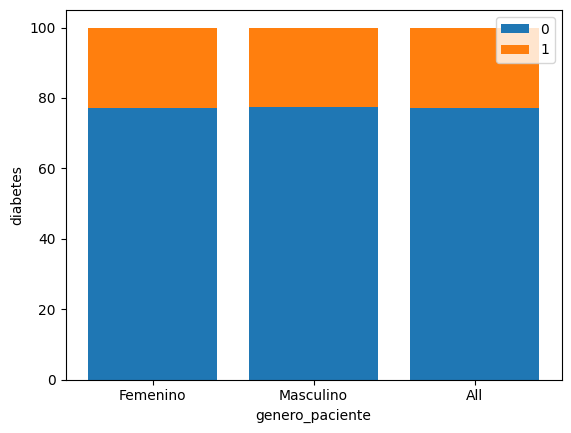

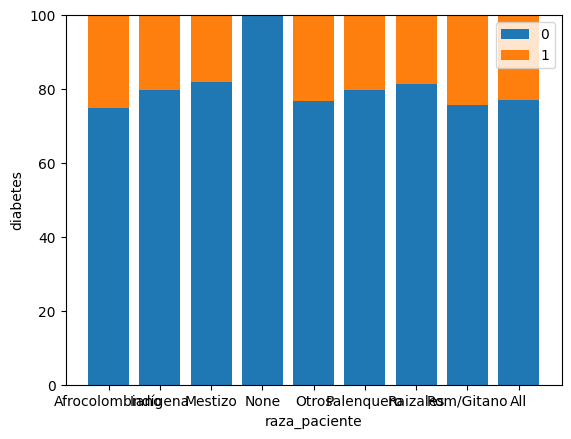

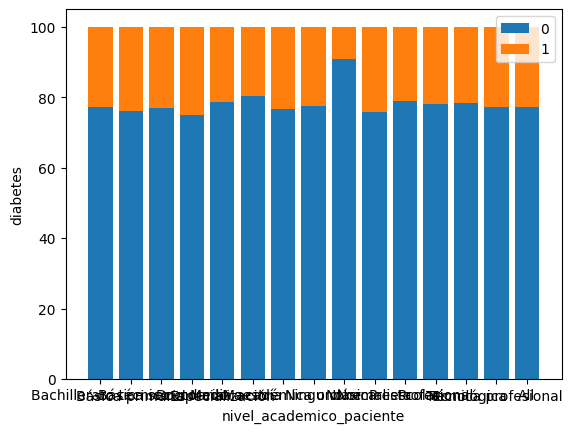

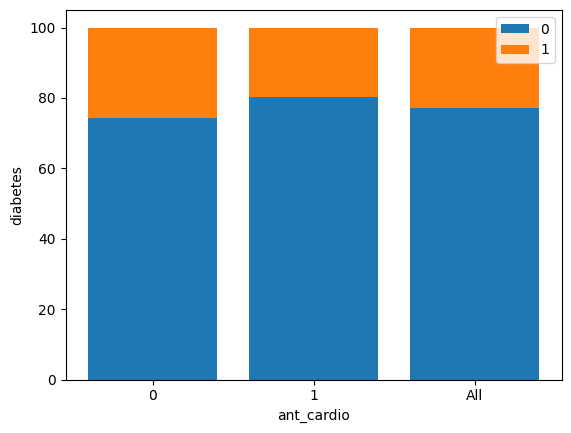

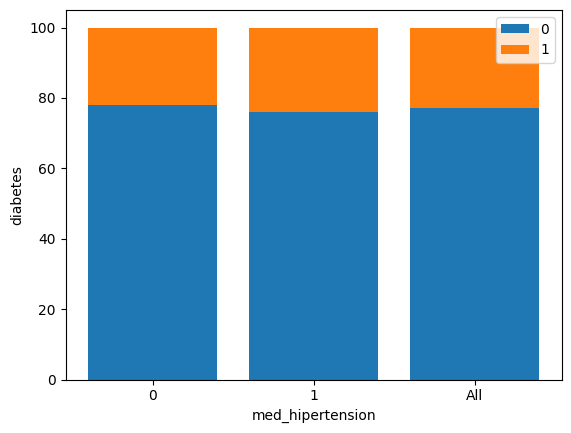

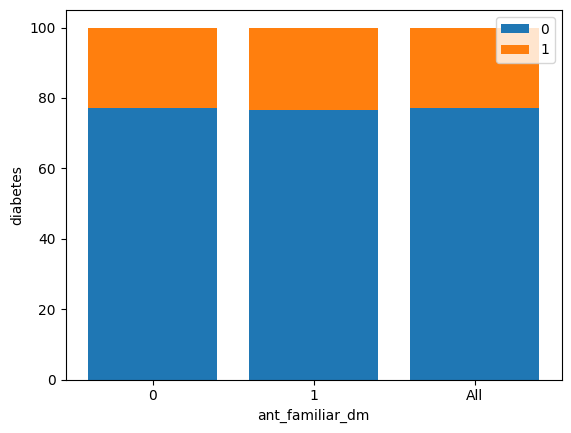

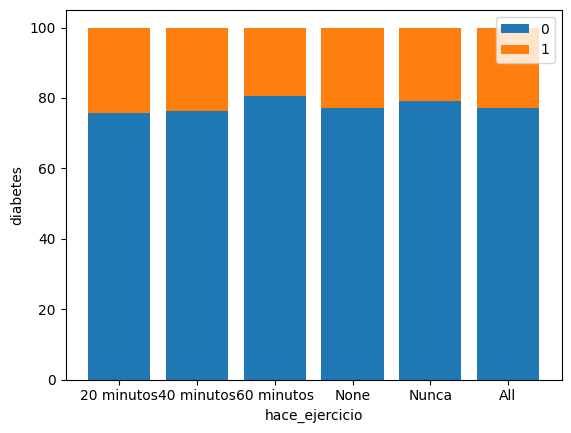

In [63]:
var2 = 'diabetes'

for column in df_categorico.columns:

    if column == var2:
        continue

    # Filtrar el df
    df_temp = df_categorico[[column,var2]][::]

    # Columna temporal para el conteo de los datos
    df_temp['temp'] = 0

    # Convertir a tipo str para la grafica
    df_temp.columns = df_temp.columns.astype(str)

    # Crear tabla de contingencia
    pivot = pd.pivot_table(df_temp, values = 'temp', index = column, columns = var2, aggfunc = 'count', margins = True)
    # Crear tabla con el perfil columna
    pf = round((pivot.T/ pivot.loc[:,'All'].values)*100,2).iloc[:-1]

    # Crear grafico de barras apiladas del perfil columna
    fig, ax = create_apilated_bars(pf)
    ax.set_xlabel(column)
    ax.set_ylabel(var2)
    plt.legend()


plt.show()